In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import zipfile
import io
import csv


def load_data(filename: str) -> pd.DataFrame:
    # tyto konstanty nemente, pomuzou vam pri nacitani
    headers = ["p1", "p36", "p37", "p2a", "weekday(p2a)", "p2b", "p6", "p7", "p8", "p9", "p10", "p11", "p12", "p13a",
               "p13b", "p13c", "p14", "p15", "p16", "p17", "p18", "p19", "p20", "p21", "p22", "p23", "p24", "p27", "p28",
               "p34", "p35", "p39", "p44", "p45a", "p47", "p48a", "p49", "p50a", "p50b", "p51", "p52", "p53", "p55a",
               "p57", "p58", "a", "b", "d", "e", "f", "g", "h", "i", "j", "k", "l", "n", "o", "p", "q", "r", "s", "t", "p5a"]

    # def get_dataframe(filename: str, verbose: bool = False) -> pd.DataFrame:
    regions = {
        "PHA": "00",
        "STC": "01",
        "JHC": "02",
        "PLK": "03",
        "ULK": "04",
        "HKK": "05",
        "JHM": "06",
        "MSK": "07",
        "OLK": "14",
        "ZLK": "15",
        "VYS": "16",
        "PAK": "17",
        "LBK": "18",
        "KVK": "19",
    }

    code_to_regions = {
        "00": "PHA" ,
        "01": "STC" ,
        "02": "JHC" ,
        "03": "PLK" ,
        "04": "ULK" ,
        "05": "HKK" ,
        "06": "JHM" ,
        "07": "MSK" ,

        "08": "None" ,
        "09": "None" ,
        "10": "None" ,
        "11": "None" ,
        "12": "None" ,
        "13": "None" ,

        "14": "OLK" ,
        "15": "ZLK" ,
        "16": "VYS" ,
        "17": "PAK" ,
        "18": "LBK" ,
        "19": "KVK" ,
    }


    #load csv into list as dictionary, later create DataFrame
    list_of_dics = []
    with zipfile.ZipFile(file = filename,mode="r") as main_zip:
        # Iterate through the contents of the outer zip file
        for year_zip_info in main_zip.infolist():
            # Read the contents of the inner zip file
            with main_zip.open(year_zip_info) as year_zip:
                inner_zip = zipfile.ZipFile(io.BytesIO(year_zip.read()), 'r')
                # Iterate through the contents of the inner zip file
                for inner_zip_info in inner_zip.infolist():
                    if(inner_zip_info.filename == "CHODCI.csv"):
                        continue
                    region_code = code_to_regions[inner_zip_info.filename[:2]]
                    with inner_zip.open(inner_zip_info) as csv_file:
                        csv_reader = csv.DictReader(io.TextIOWrapper(csv_file, encoding='cp1250'), fieldnames=headers, delimiter=';')
                        # Concatenate the CSV DataFrame with the main DataFrame
                        for line in csv_reader:
                            if(line == {}):
                                continue
                            line["region"] = region_code
                            list_of_dics.append(line)

    df = pd.DataFrame(list_of_dics)
    return df

# Ukol 2: zpracovani dat



df = load_data("data.zip")

In [3]:


def parse_data(df: pd.DataFrame, verbose: bool = False) -> pd.DataFrame:
    float_cols = ["p37", "a", "b", "d", "e", "f", "g", "o", "n", "r", "s"]
    int_cols = ["p1","p14","p37","p53"]
    new_df = df.copy(deep=True)
    new_df.drop_duplicates(subset=['p1'],inplace=True)
    for column in new_df.columns:
        if(column == "p2a"):
            new_df[column] = pd.to_datetime(new_df[column],format="%Y-%m-%d")
        elif(column == "p2b"):
            new_df[column] = pd.to_datetime(new_df[column],format="%H%M",errors="coerce")
        elif(column == "region"):
            continue
        elif(column in float_cols):
            new_df[column] = new_df[column].str.replace(",",".")

            new_df[column] = pd.to_numeric(new_df[column],errors="coerce",downcast="float")
        elif(column in int_cols):
            new_df[column] = pd.to_numeric(new_df[column],errors="coerce",downcast="integer")
        else:
            new_df[column] = new_df[column].astype('category')
    if verbose == True:
        print(f"orig_size={(df.memory_usage(deep=True).sum()/10**6):.1f} MB")
        print(f"new_size={(new_df.memory_usage(deep=True).sum()/10**6):.1f} MB")
    return new_df
ndf = parse_data(df,True)

orig_size=2501.3 MB
new_size=158.3 MB


/tmp/ipykernel_194559/2595477620.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby(['region', 'p57']).size().unstack(fill_value=0)
/home/bahno/anaconda3/envs/izv2/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bahno/anaconda3/envs/izv2/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bahno/anaconda3/envs/izv2/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_c

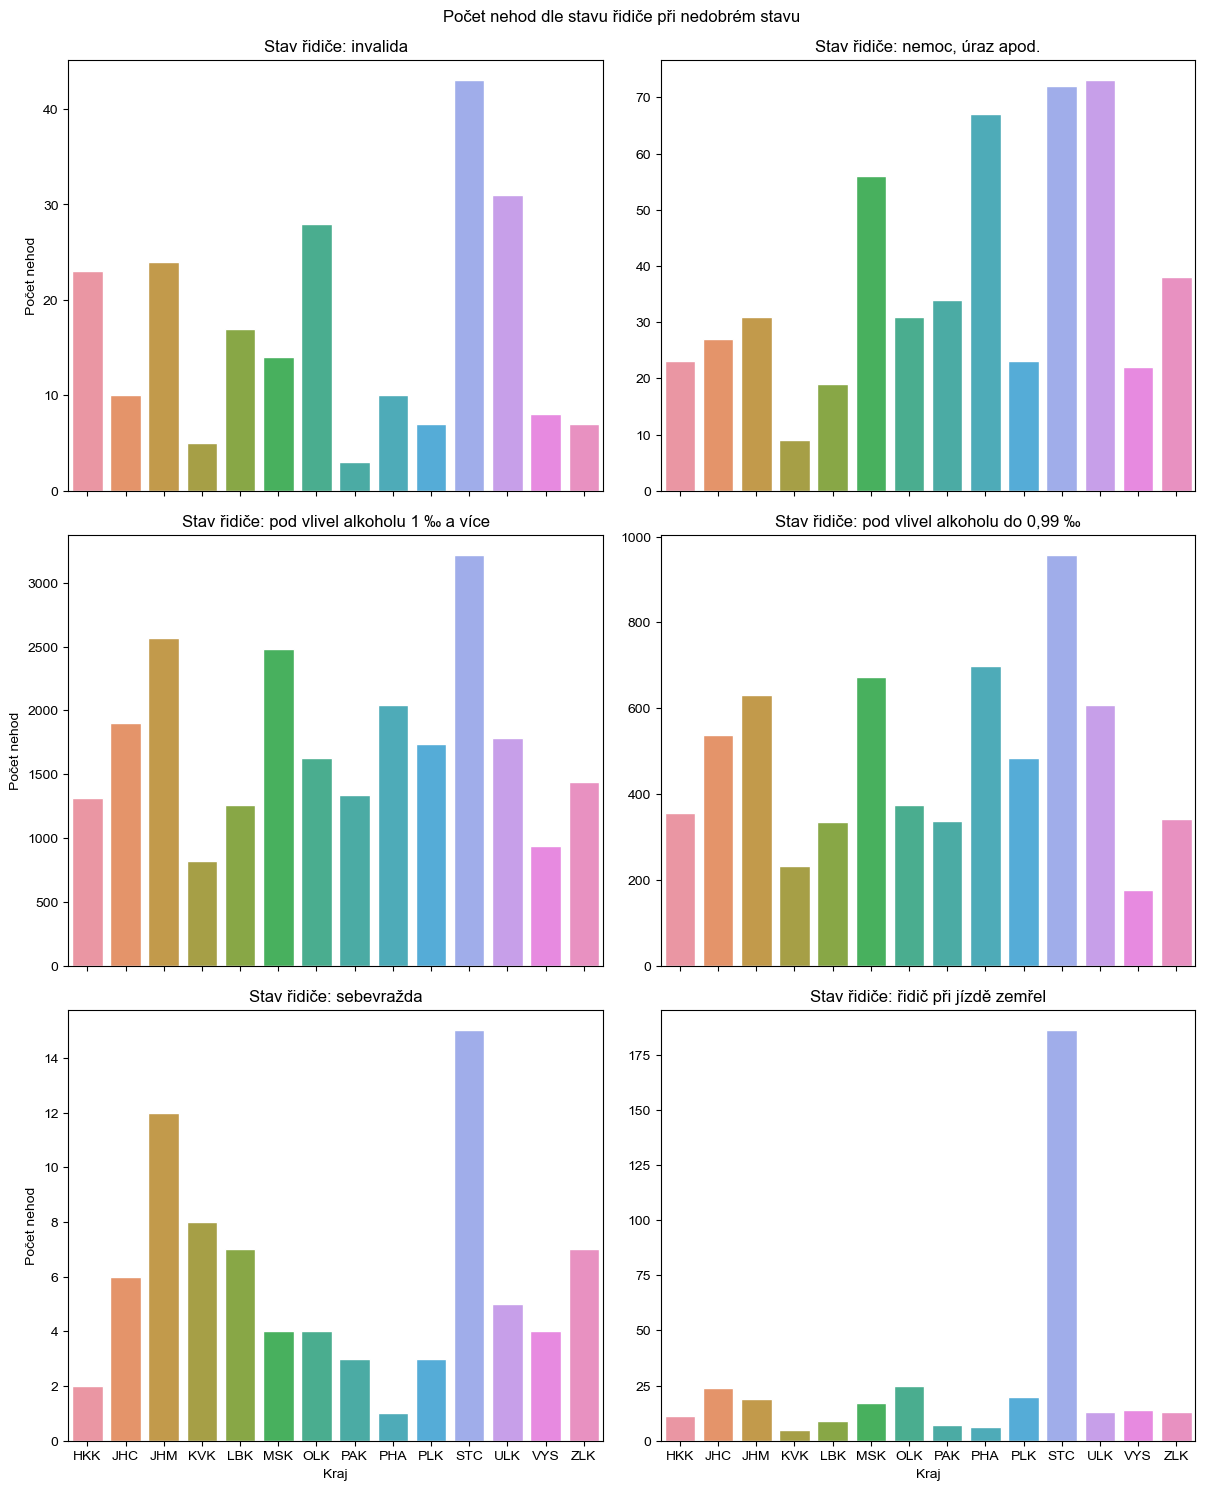

In [3]:
# Ukol 3: počty nehod oidke stavu řidiče


def plot_state(df: pd.DataFrame, fig_location: str = None,
               show_figure: bool = False):
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
    # Adjust the top margin for the main title
    plt.tight_layout(rect=[0, 0, 1, 0.96])  


    fig.suptitle("Počet nehod dle stavu řidiče při nedobrém stavu")
    plt.sca(ax[0][0])
    plt.title("Stav řidiče: invalida")
    plt.ylabel("Počet nehod")
    plt.sca(ax[0][1])
    plt.title("Stav řidiče: nemoc, úraz apod.")
    plt.sca(ax[1][0])
    plt.title("Stav řidiče: pod vlivel alkoholu 1 ‰ a více")
    plt.ylabel("Počet nehod")
    plt.sca(ax[1][1])
    plt.title("Stav řidiče: pod vlivel alkoholu do 0,99 ‰")
    plt.sca(ax[2][0])
    plt.title("Stav řidiče: sebevražda")
    plt.ylabel("Počet nehod")
    plt.xlabel("Kraj")
    plt.sca(ax[2][1])
    plt.title("Stav řidiče: řidič při jízdě zemřel")
    plt.xlabel("Kraj")



    category_mapping = {
        '0': 'other',
        '1': 'good',
        '2': 'asleep',
        '3': 'drugs',
        '4': 'little_alcohol',
        '5': 'big_alcohol',
        '6': 'ill',
        '7': 'invalida',
        '8': 'dead',
        '9': 'suicide'
    }

    df['p57'] = df['p57'].replace(category_mapping)
    # Group by region and p57, and calculate the size of each group
    result = df.groupby(['region', 'p57']).size().unstack(fill_value=0)

    sns.set_style("darkgrid")
                

    sns.barplot(x=result.index,y=result["invalida"],ax=ax[0,0])
    sns.barplot(x=result.index,y=result["ill"],ax=ax[0,1])
    sns.barplot(x=result.index,y=result["big_alcohol"],ax=ax[1,0])
    sns.barplot(x=result.index,y=result["little_alcohol"],ax=ax[1,1])
    sns.barplot(x=result.index,y=result["suicide"],ax=ax[2,0])
    sns.barplot(x=result.index,y=result["dead"],ax=ax[2,1])
    plt.setp(ax,xticklabels=[],ylabel='', xlabel='')

    ax[2,0].set_xticklabels(result.index)
    ax[2,0].set_xlabel('Kraj')
    ax[2,1].set_xticklabels(result.index)
    ax[2,1].set_xlabel('Kraj')

    ax[0,0].set_ylabel('Počet nehod')
    ax[1,0].set_ylabel('Počet nehod')
    ax[2,0].set_ylabel('Počet nehod')


    if (fig_location is not None):
        plt.savefig(fig_location,bbox_inches='tight')
    if(show_figure==True):
        plt.show()

plot_state(df=ndf,fig_location="01_state.png",show_figure=True)


In [ ]:
def plot_alcohol(df: pd.DataFrame, fig_location: str = None,
                 show_figure: bool = False):

    df['hour']=df['p2b'].dt.hour.astype(int,errors="ignore")

    #create daraframe index by region and hour with summed values for each hour
    result = df.groupby(['region', 'hour','p11']).size().unstack(fill_value=0)
    
    #sum non alcohol column into one column
    result['no_alcohol'] =  result['1']+result['2']
    #sum alcohol column into one column
    result['alcohol'] =  result['3']+result['4']+result['5']+result['6']+result['7']+result['8']+result['9']

    #converts region index to column
    result = result.reset_index()
    reg_and_hour = {}
    regions_to_plot = ['HKK','ZLK','OLK','JHM'] 
    for i in regions_to_plot:
        reg_and_hour[i] = result[result['region'] == i]


    hours = np.arange(0,24)


    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
    # Adjust the top margin for the main title
    plt.tight_layout(pad=2.8,rect=[0, 0, 1, 0.96])  


    plt.setp(ax,ylabel="Počet nehod",xlabel="Hodina")
    fig.suptitle("Počet nehod dle stavu řidiče při nedobrém stavu")


    ax[0,0].set_title("Kraj: HKK")
    ax[0,0].bar(x=hours,height=list(reg_and_hour['HKK']['no_alcohol']),color='chocolate',width=0.3)
    ax[0,0].bar(x=hours-0.3,height=list(reg_and_hour['HKK']['alcohol']),color='steelblue',width=0.3)

    ax[0,1].set_title("Kraj: ZLK")
    ax[0,1].bar(x=hours,height=list(reg_and_hour['ZLK']['no_alcohol']),color='chocolate',width=0.3)
    ax[0,1].bar(x=hours-0.3,height=list(reg_and_hour['ZLK']['alcohol']),color='steelblue',width=0.3)

    ax[1,0].set_title("Kraj: OLK")
    ax[1,0].bar(x=hours,height=list(reg_and_hour['OLK']['no_alcohol']),color='chocolate',width=0.3)
    ax[1,0].bar(x=hours-0.3,height=list(reg_and_hour['OLK']['alcohol']),color='steelblue',width=0.3)

    ax[1,1].set_title("Kraj: JHM")
    ax[1,1].bar(x=hours,height=list(reg_and_hour['JHM']['no_alcohol']),color='chocolate',width=0.3)
    ax[1,1].bar(x=hours-0.3,height=list(reg_and_hour['JHM']['alcohol']),color='steelblue',width=0.3)

    plt.setp(ax,xticks=hours,xticklabels=hours,ylim=(0,1800))

    if (fig_location is not None):
        plt.savefig(fig_location,bbox_inches='tight')
    if(show_figure==True):
        plt.show()

plot_alcohol(df=ndf,fig_location="01_alcohol.png",show_figure=True)



/home/bahno/anaconda3/envs/izv2/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bahno/anaconda3/envs/izv2/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bahno/anaconda3/envs/izv2/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bahno/anaconda3/envs/izv2/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

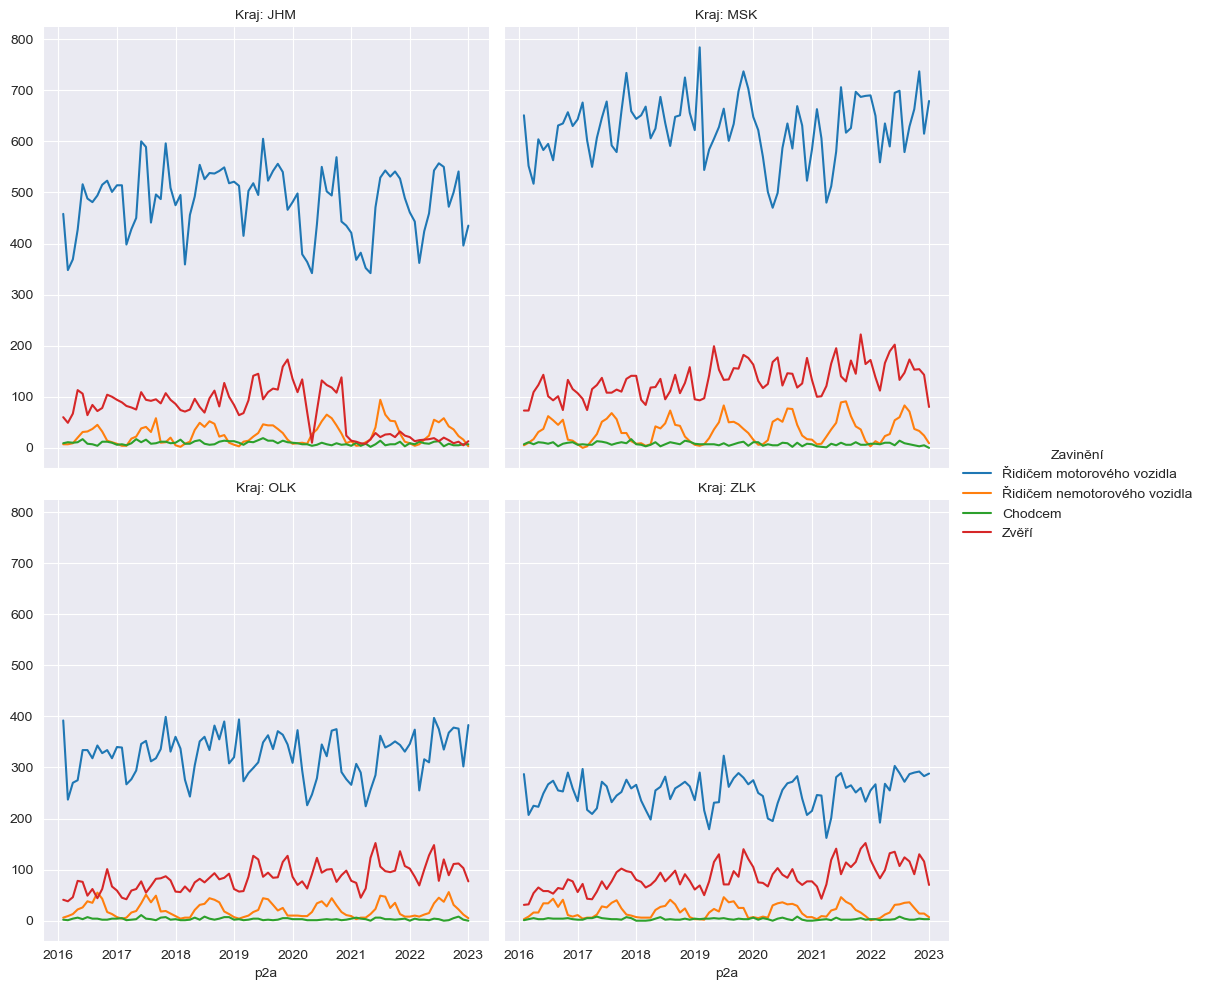

In [77]:
def plot_fault(df: pd.DataFrame, fig_location: str = None,
               show_figure: bool = False):

    p10_values = {'1':"Řidičem motorového vozidla",
                    '2':"Řidičem nemotorového vozidla",
                    '3':"Chodcem",
                    '4':"Zvěří",
                    '5':"Jiným účastníkem silničního provozu",
                    '6':"Závadou komunikace",
                    '7':"Technickou závadou vozidla",
                    '0':"jiné"}

    

    selected_regions = ["OLK","JHM","MSK","ZLK"]
    df_filtred = df[df['region'].isin(selected_regions)]
    df_filtred = df_filtred[df_filtred['p10'].isin(['1','2','3','4'])]
    #using this changes the column type from 8 categories to 4, even though it doesnt conver anything, because those columns are already filtred out
    df_filtred['p10'] = df_filtred['p10'].replace({
            '0': '1',
            '5': '2',
            '6': '3',
            '7': '4'
        })
    df_filtred['p10'] = df_filtred['p10'].replace(p10_values)


    #grou regions and days together, count diferent types of 'p10' together
    df_pivot = df_filtred.pivot_table(index=["region",'p2a'],columns=['p10'],aggfunc='count',values='p1')

    final = df_pivot.stack(level="p10").unstack(level="region")


    for region in selected_regions:
        one_region = df_pivot.loc[region]
        one_region = one_region.resample("M").sum()
        final[region] = one_region.stack(level="p10")

    final.dropna(how='all', inplace=True)

    final = final.stack(level="region").reset_index()



    ax = sns.relplot(data=final, x="p2a", y = 0,hue="p10", col="region",kind="line",col_wrap=2)

    ax.set_titles("Kraj: {col_name}")
    ax.legend.set(title="Zavinění")
    sns.set_style("darkgrid")

    if (fig_location is not None):
        plt.savefig(fig_location)
    if (show_figure == True):
        plt.show()

plot_fault(df=ndf, fig_location="03_fault.png",show_figure=True)